In [2]:
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn prophet


  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached prophet-1.2.1-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached numpy-2.3.4-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached holi

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\agile_sprint_planner\\Planix\\.venv\\Lib\\site-packages\\numpy\\_core\\tests\\test_extint128.py'
Check the permissions.



In [9]:
import pandas as pd
import matplotlib.pyplot as plt 
from prophet import Prophet


2.) LOAD DATA

In [11]:
# Load issues and sprint data
issues = pd.read_csv("Issue.csv", parse_dates=['Creation_Date', 'Resolution_Date'])

# ✅ Only include date columns that actually exist in your Sprint.csv
sprints = pd.read_csv("Sprint.csv", parse_dates=['Start_Date', 'End_Date'])

print("Issues:", issues.shape)
print("Sprints:", sprints.shape)


Issues: (200, 30)
Sprints: (100, 9)


3.) COMPUTE Sprint Velocity

In [12]:
# Check and standardize columns
issues.rename(columns={
    'SprintId': 'Sprint_ID',
    'Story_Points': 'Story_Point'
}, inplace=True)

sprints.rename(columns={
    'ID': 'Sprint_ID',
    'StartDate': 'Start_Date',
    'EndDate': 'End_Date'
}, inplace=True)

# Filter resolved issues
resolved = issues[issues['Resolution_Date'].notna()]

# Merge with sprint info
df = resolved.merge(sprints[['Sprint_ID','Start_Date','End_Date']], on='Sprint_ID', how='left')

# Calculate sprint velocity
velocity = (
    df.groupby('Sprint_ID')
      .agg({'Story_Point':'sum', 'End_Date':'max'})
      .reset_index()
      .rename(columns={'Story_Point':'velocity','End_Date':'ds'})
)


4.) PREPARE DATA FOR FORECASTING


In [13]:
# Prophet expects two columns: ds (date), y (value)
velocity = velocity.rename(columns={'velocity':'y'})

# Drop any missing or invalid dates
velocity = velocity.dropna(subset=['ds','y'])


5.) Build Prophet Model

In [14]:
model = Prophet(
    growth='linear',
    changepoint_prior_scale=0.1,
    seasonality_mode='additive',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.add_seasonality(name='sprint_cycle', period=14, fourier_order=3)  # ~2 weeks per sprint
model.fit(velocity) 


01:11:47 - cmdstanpy - INFO - Chain [1] start processing
01:11:47 - cmdstanpy - INFO - Chain [1] done processing


6.) Forecast Future Velocity

In [15]:
# Predict next 6 sprints (~12 weeks)
future = model.make_future_dataframe(periods=84, freq='D')
forecast = model.predict(future)

# Filter to sprint-level (every 14 days)
forecast_sprint = forecast[forecast['ds'].isin(velocity['ds']) | (forecast['ds'].dt.dayofweek == 0)]


7.) Visualize Forecast

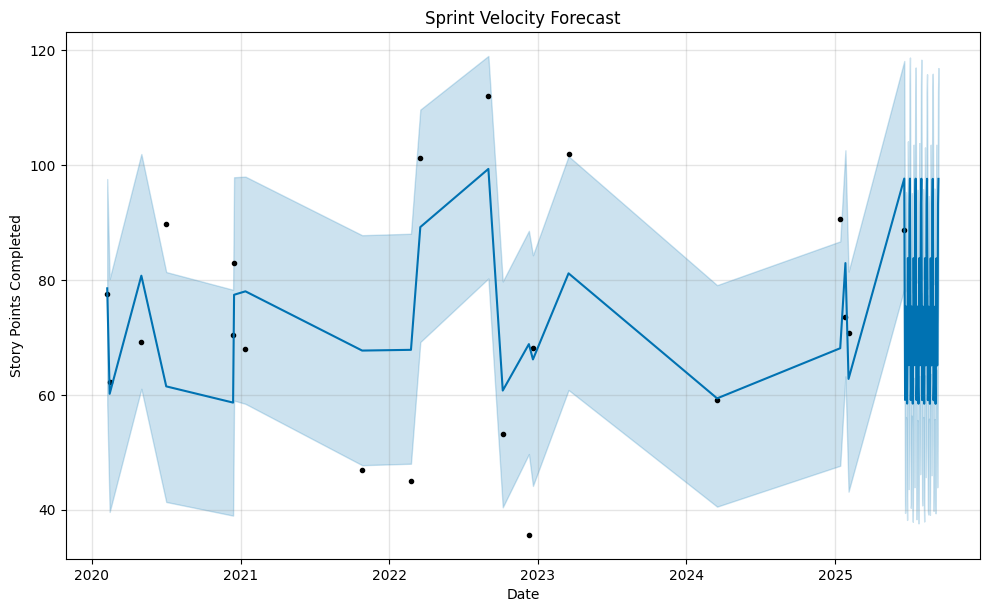

In [16]:
model.plot(forecast)
plt.title("Sprint Velocity Forecast")
plt.xlabel("Date")
plt.ylabel("Story Points Completed")
plt.show()


8.) Trend & Components

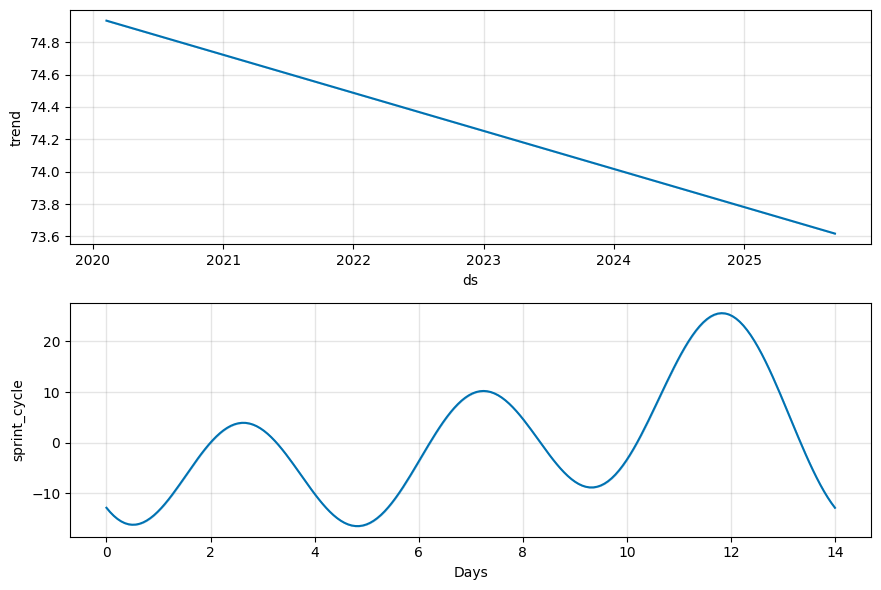

In [17]:
model.plot_components(forecast)
plt.show()


9.) Evaluate Forecast Accuracy (Backtest)

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error 
import numpy as np

# Align actual vs predicted
actual_forecast = forecast.merge(velocity, on='ds', how='inner')
mae = mean_absolute_error(actual_forecast['y'], actual_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(actual_forecast['y'], actual_forecast['yhat']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl (8.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.5 MB ? eta -:--:--
    --------------------------------------- 0.5/38.5 MB 1.2 MB/s eta 0:00:31
    --------------------------------------- 0.8/38.5 MB 1.4 MB/s eta 0:00:28
   - -------------------------------------- 1.0/38.5 MB 1.5 MB/s eta 0:00:26
   - -------------------------------------- 1.8/38.5 MB 1.8 MB/s eta 0:00:21
   -- ------------------------------------- 2.4/38.5 MB 2.0 MB/s eta 0:00:19
   -- ------------------------------------- 2.9/38.5 MB 2.1 MB/s eta 0:00:17


In [23]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv('forecast_velocity.csv', index=False)
print("Forecast saved to forecast_velocity.csv")


Forecast saved to forecast_velocity.csv


01:15:22 - cmdstanpy - INFO - Chain [1] start processing
01:15:22 - cmdstanpy - INFO - Chain [1] done processing


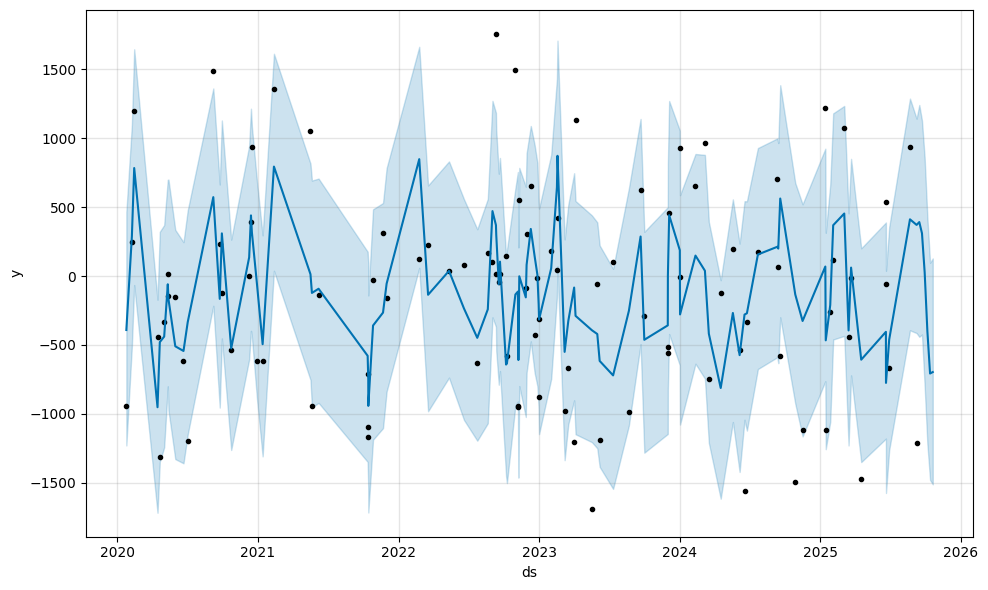

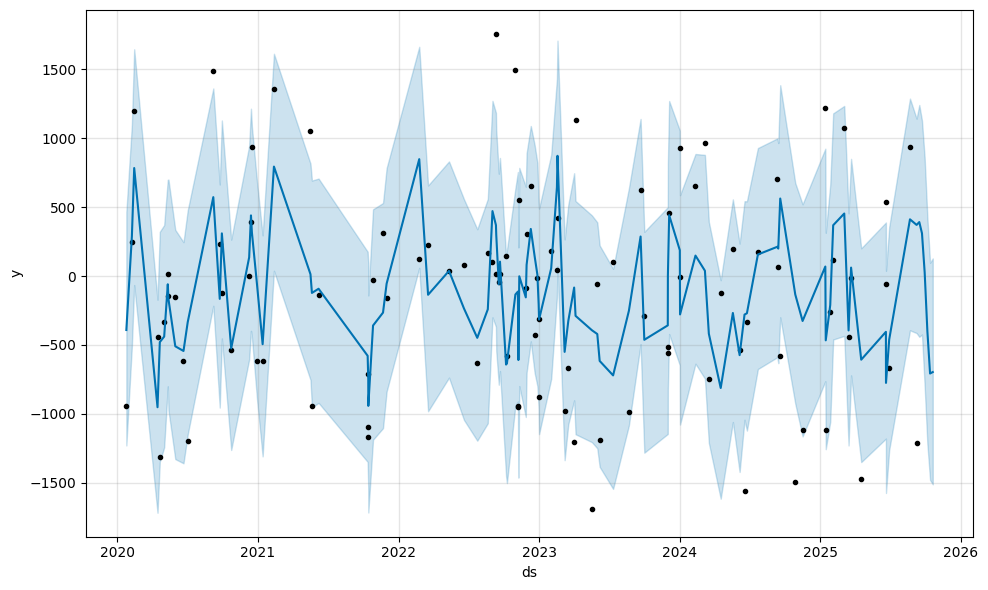

In [25]:
# Calculate sprint duration (completion time)
# Convert to datetime if not already
sprints['Start_Date'] = pd.to_datetime(sprints['Start_Date'], errors='coerce')
sprints['Complete_Date'] = pd.to_datetime(sprints['Complete_Date'], errors='coerce')

# Now calculate duration in days
sprints['completion_time_days'] = (sprints['Complete_Date'] - sprints['Start_Date']).dt.days



# Prepare time series data
duration = sprints[['End_Date', 'completion_time_days']].rename(columns={'End_Date':'ds', 'completion_time_days':'y'})
duration = duration.dropna()

# Fit Prophet model
model = Prophet()
model.fit(duration)
forecast = model.predict(model.make_future_dataframe(periods=6, freq='W'))
model.plot(forecast)


01:15:26 - cmdstanpy - INFO - Chain [1] start processing
01:15:26 - cmdstanpy - INFO - Chain [1] done processing


Columns found in Sprint.csv: ['Sprint_ID', 'Jira_ID', 'Name', 'State', 'Start_Date', 'End_Date', 'Activated_Date', 'Complete_Date', 'Project_ID']
Rows: 100
Using start column: Start_Date
Using completion column: Complete_Date

Prepared duration data (head):
           Start_Date                  ds    y
0 2020-01-24 05:16:00 2020-09-06 06:19:14  226
1 2020-01-11 11:56:43 2020-09-13 03:13:58  245
2 2020-04-18 12:24:46 2020-10-19 07:10:40  183
3 2020-04-23 02:36:12 2020-11-03 03:36:11  194
4 2020-10-12 20:35:12 2021-01-26 04:42:05  105

Stats:
count      44.000000
mean      532.727273
std       490.815618
min         1.000000
25%       120.750000
50%       352.000000
75%       939.250000
max      1757.000000
Name: y, dtype: float64

Using median sprint interval (days) = 29

Fitting Prophet model...

Predicting on historical sprint end dates for evaluation...

Backtest results on historical data: MAE = 316.64 days, RMSE = 379.51 days

✅ Saved forecast successfully to: completion_time_fore

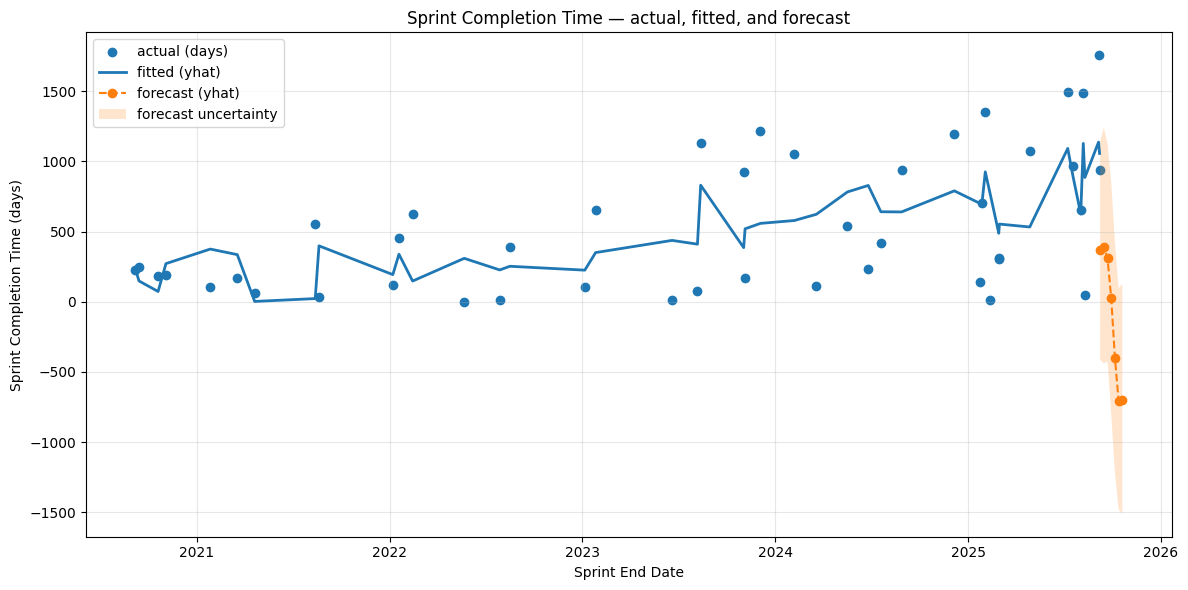

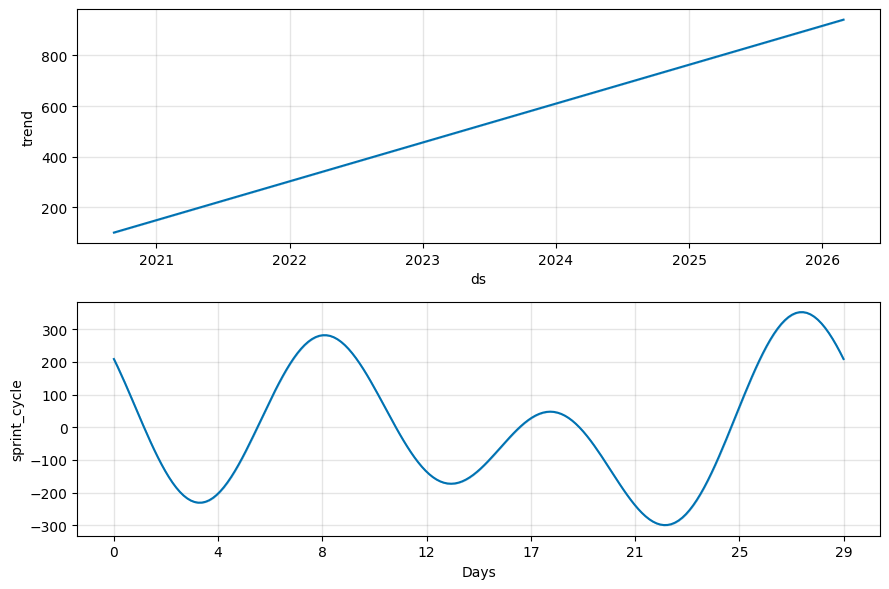


Forecast sample (historical + next forecasts):
                    ds       y         yhat   yhat_lower   yhat_upper  \
41 2025-08-09 23:55:37    45.0   885.731650   391.958971  1379.955720   
42 2025-09-04 21:12:51  1757.0  1137.824543   652.290534  1600.380405   
43 2025-09-06 19:44:00   940.0  1057.325021   553.549077  1541.217029   
44 2025-09-07 21:31:26     NaN   371.200010  -413.852495  1142.215386   
45 2025-09-14 21:31:26     NaN   391.761434  -440.766171  1241.567363   
46 2025-09-21 21:31:26     NaN   310.302838  -424.125325  1128.638660   
47 2025-09-28 21:31:26     NaN    25.822258  -801.069616   855.862732   
48 2025-10-05 21:31:26     NaN  -398.844713 -1217.573780   426.366584   
49 2025-10-12 21:31:26     NaN  -707.178058 -1479.499499    96.145261   
50 2025-10-19 21:31:26     NaN  -696.644871 -1511.246336   128.057257   

          type  
41  historical  
42  historical  
43  historical  
44    forecast  
45    forecast  
46    forecast  
47    forecast  
48    foreca

In [26]:
# If you haven't installed prophet yet, run this first in a notebook cell:
# !pip install prophet pandas matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prophet import fallback (handles prophet vs old fbprophet name)
try:
    from prophet import Prophet
except Exception:
    try:
        from fbprophet import Prophet
    except Exception as e:
        raise ImportError(
            "Prophet not available. Install with `pip install prophet` (or `pip install fbprophet` for older installs)."
        )

# ----------------------------
# 1) Load Sprint CSV
# ----------------------------
sprints = pd.read_csv("Sprint.csv")   # change path if your CSV is elsewhere
print("Columns found in Sprint.csv:", sprints.columns.tolist())
print("Rows:", len(sprints))

# ----------------------------
# 2) Helper: find likely column names (case/format tolerant)
# ----------------------------
def _norm(s):
    s = str(s)
    return "".join(ch for ch in s.lower() if ch.isalnum())

def find_first_matching_col(cols, candidates):
    # exact normalized match first (priority to candidate order)
    for cand in candidates:
        cand_n = _norm(cand)
        for col in cols:
            if _norm(col) == cand_n:
                return col
    # then partial matching (candidate substring in column or vice versa)
    for cand in candidates:
        cand_n = _norm(cand)
        for col in cols:
            col_n = _norm(col)
            if cand_n in col_n or col_n in cand_n:
                return col
    return None

possible_start_cols = [
    "Start_Date","StartDate","Start","Sprint_Start","Start_At","Started_At","Start Date"
]
possible_completion_cols = [
    "Completion_Date","Complete_Date","Completed_At","Closed_Date",
    "End_Date","EndDate","CloseDate","Completed Date","End Date","CompletedOn","Completed_On"
]

start_col = find_first_matching_col(sprints.columns.tolist(), possible_start_cols)
completion_col = find_first_matching_col(sprints.columns.tolist(), possible_completion_cols)

if start_col is None:
    raise ValueError(f"Start column not found. Available columns: {sprints.columns.tolist()}")
if completion_col is None:
    raise ValueError(f"Completion column not found. Available columns: {sprints.columns.tolist()}")

print(f"Using start column: {start_col}")
print(f"Using completion column: {completion_col}")

# ----------------------------
# 3) Convert to datetime (safe) and compute duration
# ----------------------------
sprints[start_col] = pd.to_datetime(sprints[start_col], errors='coerce')
sprints[completion_col] = pd.to_datetime(sprints[completion_col], errors='coerce')

# compute completion_time_days
sprints['completion_time_days'] = (sprints[completion_col] - sprints[start_col]).dt.days

# Prepare DataFrame with Prophet columns
duration = sprints[[start_col, completion_col, 'completion_time_days']].rename(
    columns={completion_col: 'ds', 'completion_time_days': 'y'}
)

# Clean: drop rows where ds or y is missing, and remove negative durations
duration = duration.dropna(subset=['ds', 'y'])
duration = duration[duration['y'] >= 0].copy()   # drop negative durations (if any)

# Sort by date
duration = duration.sort_values('ds').reset_index(drop=True)

if duration.shape[0] == 0:
    raise ValueError("No valid sprint records found after cleaning. Check date parsing and CSV contents.")

print("\nPrepared duration data (head):")
print(duration.head())
print("\nStats:")
print(duration['y'].describe())

if duration.shape[0] < 3:
    print("\n⚠️ Warning: fewer than 3 data points. Prophet may have trouble fitting reliable trends with very few rows.")

# ----------------------------
# 4) Derive sprint cadence (median days between sprints) for future dates
# ----------------------------
if duration.shape[0] >= 2:
    diffs = duration['ds'].diff().dt.days.dropna()
    median_interval_days = int(max(1, np.round(diffs.median())))
else:
    median_interval_days = 14  # fallback: assume fortnightly sprints

print(f"\nUsing median sprint interval (days) = {median_interval_days}")

# ----------------------------
# 5) Fit Prophet model
# ----------------------------
model = Prophet(
    growth='linear',
    changepoint_prior_scale=0.1,
    seasonality_mode='additive',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)
# add a seasonality approximately equal to sprint cadence (helps capture cyclic effects)
try:
    model.add_seasonality(name='sprint_cycle', period=median_interval_days, fourier_order=3)
except Exception:
    # if median_interval_days is 0 or invalid, skip adding custom seasonality
    pass

print("\nFitting Prophet model...")
model.fit(duration[['ds','y']])

# ----------------------------
# 6) Backtest / fitted values (on observed ds)
# ----------------------------
print("\nPredicting on historical sprint end dates for evaluation...")
hist_pred = model.predict(duration[['ds']])
actual_vs_pred = duration[['ds','y']].merge(
    hist_pred[['ds','yhat','yhat_lower','yhat_upper']],
    on='ds', how='left'
).sort_values('ds')

mae = mean_absolute_error(actual_vs_pred['y'], actual_vs_pred['yhat'])
mse = mean_squared_error(actual_vs_pred['y'], actual_vs_pred['yhat'])
rmse = np.sqrt(mse)

print(f"\nBacktest results on historical data: MAE = {mae:.2f} days, RMSE = {rmse:.2f} days")

# ----------------------------
# 7) Forecast next N sprints (generate exact sprint-level future dates)
# ----------------------------
n_future_sprints = 6   # change this to forecast more/fewer sprints
last_ds = duration['ds'].max()
future_ds = [last_ds + pd.Timedelta(days=median_interval_days * i) for i in range(1, n_future_sprints + 1)]
future_df = pd.DataFrame({'ds': future_ds})

future_pred = model.predict(future_df)

# ----------------------------
# 8) Combine Historical + Future Forecasts Safely
# ----------------------------

# Reset indexes to avoid duplicate or misaligned indexes
historical_out = hist_pred[['ds','yhat','yhat_lower','yhat_upper']].copy()
historical_out['y'] = duration['y'].values
historical_out['type'] = 'historical'
historical_out.reset_index(drop=True, inplace=True)

future_out = forecast[['ds','yhat','yhat_lower','yhat_upper']].copy()
future_out = future_out[future_out['ds'] > duration['ds'].max()].reset_index(drop=True)
future_out['y'] = np.nan
future_out['type'] = 'forecast'

# ✅ Ensure consistent columns and unique index before concatenation
forecast_df = pd.concat(
    [historical_out[['ds','y','yhat','yhat_lower','yhat_upper','type']],
     future_out[['ds','y','yhat','yhat_lower','yhat_upper','type']]],
    ignore_index=True
).reset_index(drop=True)

# ✅ Save safely to CSV
forecast_df.to_csv('completion_time_forecast.csv', index=False)
print("\n✅ Saved forecast successfully to: completion_time_forecast.csv")

# ----------------------------
# 9) Plot results: actual (points), fitted (line), future forecasts
# ----------------------------
plt.figure(figsize=(12,6))
plt.scatter(historical_out['ds'], historical_out['y'], label='actual (days)', marker='o')
plt.plot(historical_out['ds'], historical_out['yhat'], label='fitted (yhat)', linewidth=2)
plt.plot(future_out['ds'], future_out['yhat'], linestyle='--', marker='o', label='forecast (yhat)')
plt.fill_between(future_out['ds'].astype('datetime64[ns]'),
                 future_out['yhat_lower'],
                 future_out['yhat_upper'],
                 alpha=0.2, label='forecast uncertainty')
plt.xlabel('Sprint End Date')
plt.ylabel('Sprint Completion Time (days)')
plt.title('Sprint Completion Time — actual, fitted, and forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 10) Prophet components (trend + seasonality)
# ----------------------------
# combine duration ds + future ds for components visualization
component_input = pd.concat([duration[['ds']], future_df], ignore_index=True)
comp_pred = model.predict(component_input)
model.plot_components(comp_pred)
plt.tight_layout()
plt.show()

# ----------------------------
# 11) Quick view of the forecast dataframe
# ----------------------------
print("\nForecast sample (historical + next forecasts):")
print(forecast_df.sort_values('ds').tail(10))


In [36]:
# --- 12. MODEL PERSISTENCE (Save Prophet Model) ---

import joblib
import os

# Define a directory to save your model
SAVE_DIR = r"D:\spm_project\ai_ml_integration\models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Define the full model save path
MODEL_PATH = os.path.join(SAVE_DIR, "sprint_completion_time_prophet.pkl")

# Save the trained Prophet model
joblib.dump(model, MODEL_PATH)

print(f"\n✅ Prophet model saved successfully to: {MODEL_PATH}")

# (Optional) Save forecast data as well
FORECAST_PATH = os.path.join(SAVE_DIR, "completion_time_forecast.csv")
forecast_df.to_csv(FORECAST_PATH, index=False)

print(f"✅ Forecast data also saved to: {FORECAST_PATH}")



✅ Prophet model saved successfully to: D:\spm_project\ai_ml_integration\models\sprint_completion_time_prophet.pkl
✅ Forecast data also saved to: D:\spm_project\ai_ml_integration\models\completion_time_forecast.csv


In [ ]:
import joblib
from prophet import Prophet
import pandas as pd

# Load model
MODEL_PATH = r"D:\spm_project\ai_ml_integration\models\sprint_completion_time_prophet.pkl"
model = joblib.load(MODEL_PATH)
print("✅ Prophet model loaded successfully!")

# Example: Predict next 6 sprints
future_df = model.make_future_dataframe(periods=6, freq='W')
forecast = model.predict(future_df)

# Display results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


In [27]:
# 13) Export trained model for Planix backend
import os, joblib

# Resolve path to Planix models directory relative to this notebook
# Notebook lives in: D:\agile_sprint_planner\Planix\ML Models
# We want to save to: D:\agile_sprint_planner\Planix\planix\src\models\ts_model.pkl
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
PLANIX_MODELS_DIR = os.path.join(PROJECT_ROOT, 'planix', 'src', 'models')
os.makedirs(PLANIX_MODELS_DIR, exist_ok=True)

MODEL_EXPORT_PATH = os.path.join(PLANIX_MODELS_DIR, 'ts_model.pkl')

# Assumes `model` is the trained forecasting model defined above
joblib.dump(model, MODEL_EXPORT_PATH)
print(f"✅ Saved trained model to: {MODEL_EXPORT_PATH}")


✅ Saved trained model to: d:\agile_sprint_planner\Planix\planix\src\models\ts_model.pkl
